In [113]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle

In [114]:
def loadData(dirname, test=False):
    data=pd.read_csv(dirname)

    data=data.dropna()

    data['Image']=data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values

    imgs=np.vstack(data['Image'].values)/255
    imgs=imgs.reshape(data.shape[0],96,96)
    imgs=imgs.astype(np.float32)

    if test==False:
        points=data[data.columns[:-1]].values 

        points=points/96 - 0.5
        points=points.astype(np.float32)

    imgs,points=shuffle(imgs,points)

    return imgs,points

In [115]:
imgs_train,points_train=loadData('training.csv')
imgs_test,points_test=loadData('test.csv')

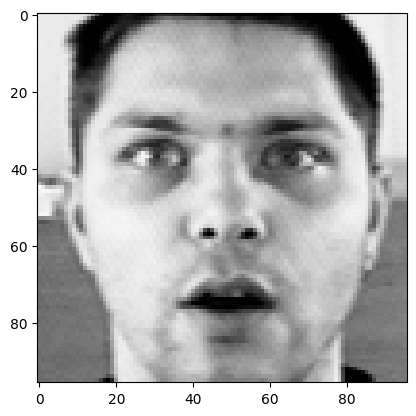

In [116]:
plt.imshow(np.squeeze(imgs_train[1]), cmap='gray')

In [117]:
def plotKeyPoints(img, points):
    plt.imshow(img,cmap='gray')

    for i in range(0,30,2):
        plt.scatter((points[i]+0.5)*96, (points[i+1]+0.5)*96,color='red')

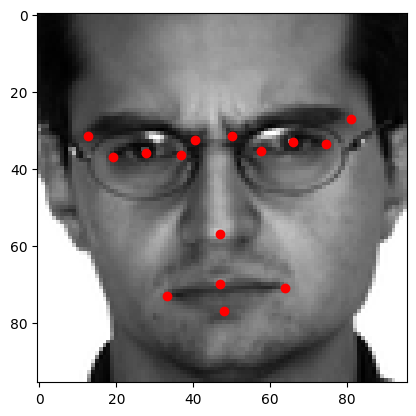

In [118]:
id=81
plotKeyPoints(imgs_train[id],points_train[id])

In [119]:
def augment_data(img,points):
    rows,cols=img.shape
    new_img=np.copy(img)

    for i in range(96):
        for j in range(48):
            temp=img[i][j]
            new_img[i][j]=img[i][cols-j-1]
            new_img[i][cols-j-1]=temp

    new_points=np.copy(points)
    
    for i in range(0,30,2):
        new_points[i]=-points[i]

    return new_img, new_points

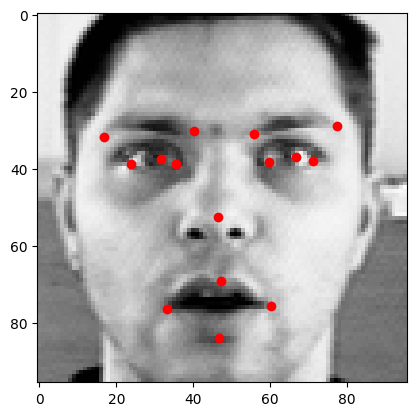

In [120]:
flip_img, flip_points = augment_data(imgs_train[1], points_train[1])
plotKeyPoints(flip_img, flip_points)

In [121]:
aug_imgs_train = []
aug_points_train = []

# apply flipping operation
for i in range(0,imgs_train.shape[0]):
    aug_img, aug_point = augment_data(imgs_train[i], points_train[i])
     # original data
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
    
    # augmented data
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

(4280, 96, 96)
(4280, 30)


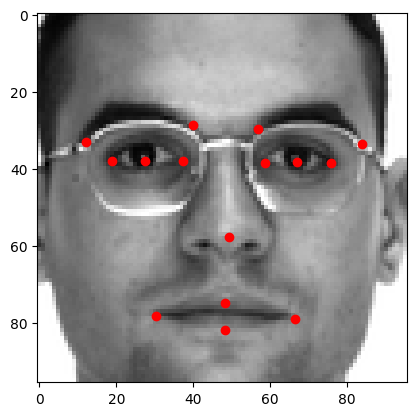

In [122]:
plotKeyPoints(aug_imgs_train[id-1], aug_points_train[id-1])

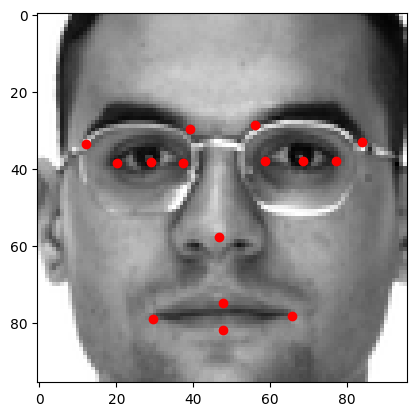

In [123]:
plotKeyPoints(aug_imgs_train[id], aug_points_train[id])

In [124]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, History
from keras.optimizers import Adam
from keras.models import load_model

In [125]:
aug_imgs_train = aug_imgs_train.reshape(aug_imgs_train.shape[0], 96, 96, 1)

In [126]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(30))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 94, 94, 16)        160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 10, 10, 64)      

In [127]:
checkpoint = ModelCheckpoint('best_model.h5', 
                             monitor='val_loss',  # Monitor validation loss
                             verbose=1, 
                             save_best_only=True,  # Save only the best model
                             mode='min',  # The mode can be 'min' or 'max' depending on the monitored metric
                             save_weights_only=False,  # Save the entire model, not just the weights
                             period=1)  # Specifies the number of epochs before a model checkpoint is saved

# Train the model with the checkpoint callback
hist = model.fit(imgs_train, 
                 points_train, 
                 validation_split=0.2, 
                 batch_size=64, 
                 shuffle=True, 
                 epochs=150, 
                 verbose=1, 
                 callbacks=[checkpoint])

Epoch 1/150
27/27 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.4883
Epoch 1: val_loss improved from inf to 0.00151, saving model to best_model.h5
27/27 [==============================] - 2s 45ms/step - loss: 0.0061 - accuracy: 0.4883 - val_loss: 0.0015 - val_accuracy: 0.7336
Epoch 2/150
24/27 [=========================>....] - ETA: 0s - loss: 0.0017 - accuracy: 0.6107
Epoch 2: val_loss improved from 0.00151 to 0.00118, saving model to best_model.h5
27/27 [==============================] - 1s 28ms/step - loss: 0.0017 - accuracy: 0.6151 - val_loss: 0.0012 - val_accuracy: 0.7336
Epoch 3/150
25/27 [==========================>...] - ETA: 0s - loss: 0.0015 - accuracy: 0.6506
Epoch 3: val_loss improved from 0.00118 to 0.00111, saving model to best_model.h5
27/27 [==============================] - 1s 27ms/step - loss: 0.0015 - accuracy: 0.6513 - val_loss: 0.0011 - val_accuracy: 0.7336
Epoch 4/150
25/27 [==========================>...] - ETA: 0s - loss: 0.0014 - accur

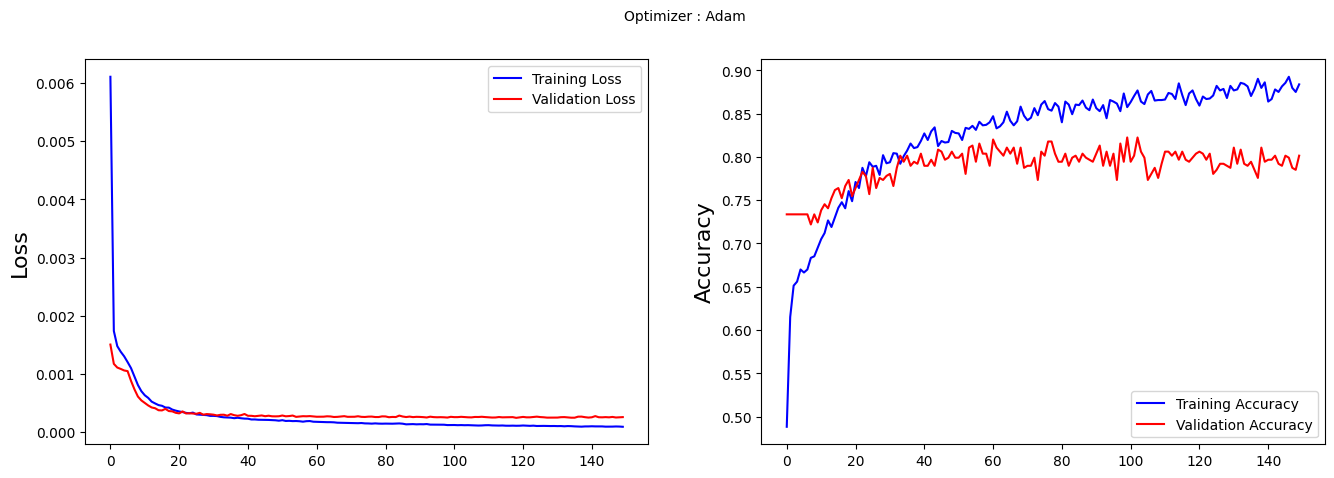

In [128]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# accuracy plot
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

56/56 [==============================] - 0s 3ms/step


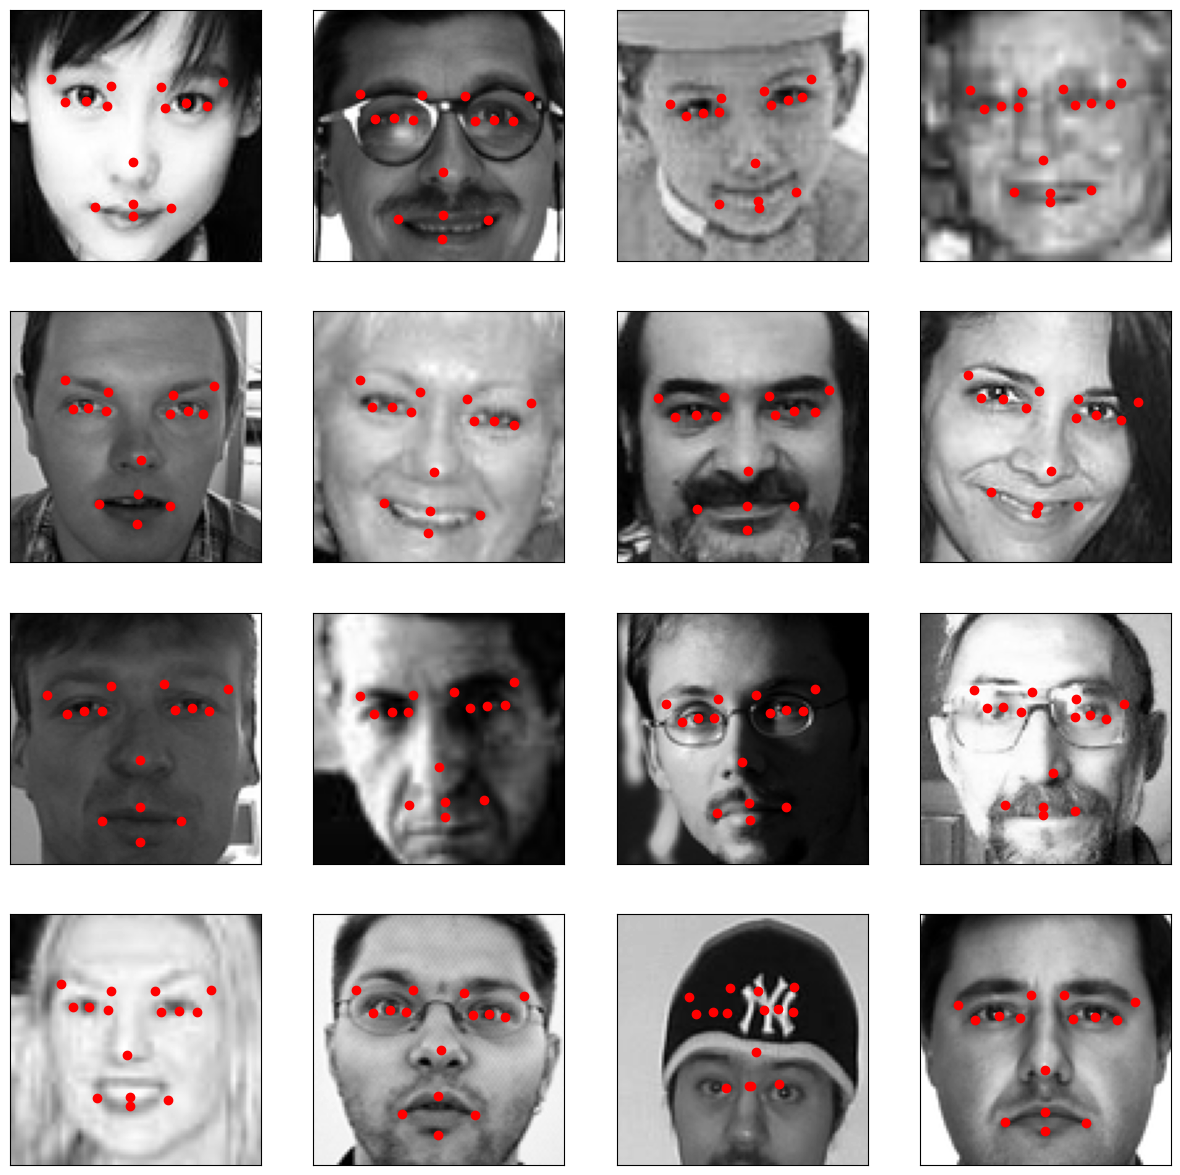

In [129]:
fig = plt.figure(figsize=(15,15))
# make test images keypoints prediction
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plotKeyPoints(imgs_test[i], np.squeeze(points_test[i]))

In [130]:
checkpoint = ModelCheckpoint('best_model_aug.h5', 
                             monitor='val_loss',  # Monitor validation loss
                             verbose=1, 
                             save_best_only=True,  # Save only the best model
                             mode='min',  # The mode can be 'min' or 'max' depending on the monitored metric
                             save_weights_only=False,  # Save the entire model, not just the weights
                             period=1)  # Specifies the number of epochs before a model checkpoint is saved

# Train the model with the checkpoint callback
hist = model.fit(aug_imgs_train, 
                 aug_points_train, 
                 validation_split=0.2, 
                 batch_size=64, 
                 shuffle=True, 
                 epochs=150, 
                 verbose=1, 
                 callbacks=[checkpoint])

Epoch 1/150
52/54 [===========================>..] - ETA: 0s - loss: 0.0206 - accuracy: 0.6562
Epoch 1: val_loss improved from inf to 0.01853, saving model to best_model_aug.h5
54/54 [==============================] - 2s 21ms/step - loss: 0.0205 - accuracy: 0.6574 - val_loss: 0.0185 - val_accuracy: 0.7044
Epoch 2/150
53/54 [============================>.] - ETA: 0s - loss: 0.0177 - accuracy: 0.6751
Epoch 2: val_loss improved from 0.01853 to 0.01668, saving model to best_model_aug.h5
54/54 [==============================] - 1s 24ms/step - loss: 0.0177 - accuracy: 0.6749 - val_loss: 0.0167 - val_accuracy: 0.7044
Epoch 3/150
53/54 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.6748
Epoch 3: val_loss improved from 0.01668 to 0.01561, saving model to best_model_aug.h5
54/54 [==============================] - 1s 22ms/step - loss: 0.0159 - accuracy: 0.6752 - val_loss: 0.0156 - val_accuracy: 0.6939
Epoch 4/150
52/54 [===========================>..] - ETA: 0s - loss: 0.

56/56 [==============================] - 0s 3ms/step


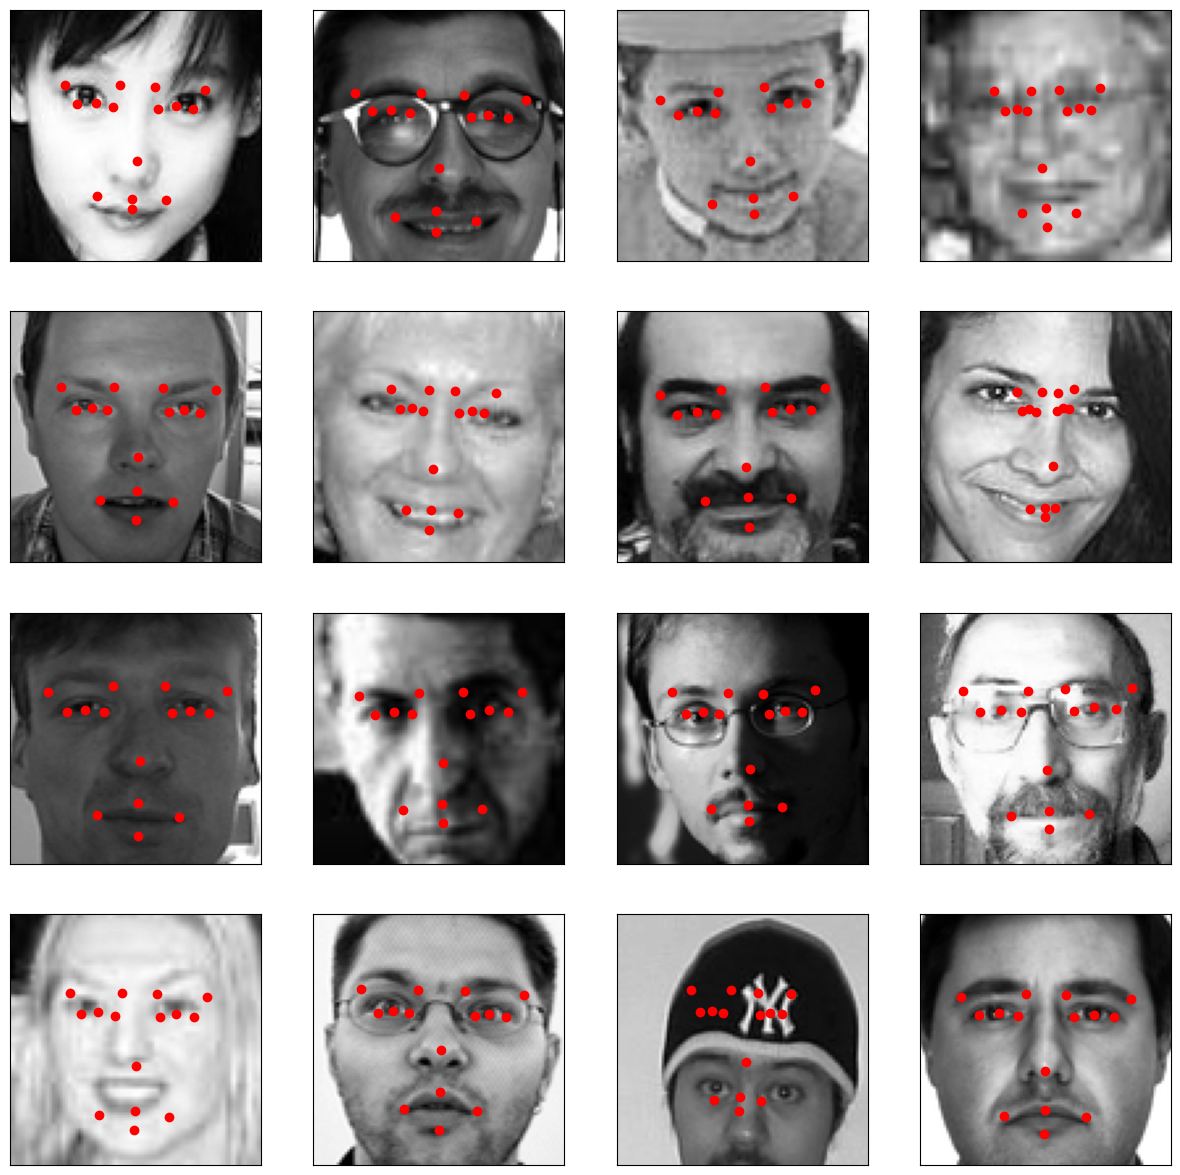

In [131]:
fig = plt.figure(figsize=(15,15))
# make test images keypoints prediction
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plotKeyPoints(imgs_test[i], np.squeeze(points_test[i]))